Based on Diagnosing and Enhancing VAE. 
1st Stage : Reconstruction 
- X -> Z -> X'
- Even if the reconstruction is very good, the distribution of X is not well estimated (because of the latent space not regularised enough)
- Latent space is not close enough to a N(0,1), but if it's closer, the reconstruction is very bad

2nd Stage : forcing the latent space to be close to a N(0,1)
- Z -> U -> Z'
- With the first stage, we are sure the reconstuction is good 
- The second stage focus on imporving the generation by mapping Z to U wich is closer to a N(0,1)

Generation :
- Sampling U -> Z' -> X'

Important : the two stages have to be trained separatly  

In [1]:
import altair as alt

from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pyvinecopulib as pv

import matplotlib.pyplot as plt
import numpy as np

from traffic.core import Traffic
from traffic.core.projection import EuroPP

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

# First Stage

In [2]:
dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_162-216_noga_tilFAF.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDataset
    Number of datapoints: 4414
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
from os import walk

filenames = next(walk("../../deep_traffic_generation/lightning_logs/tcvae/version_9/checkpoints"), (None, None, []))[2]

FirstStage = TCVAE.load_from_checkpoint(
    "../../deep_traffic_generation/lightning_logs/tcvae/version_9/checkpoints/" + filenames[0],
    hparams_file="../../deep_traffic_generation/lightning_logs/tcvae/version_9/hparams.yaml",
    dataset_params=dataset.parameters,
)
FirstStage.eval()

TCVAE(
  (encoder): Sequential(
    (0): TCN(
      (network): Sequential(
        (0): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(4, 64, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (downsample): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        )
        (1): ResidualBlock(
          (tmp_block1): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (tmp_block2): TemporalBlock(
            (conv): Conv1d(64, 64, kernel_size=(16,), stride=(1,), dilation=(2,))
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (2): ResidualBlock(
          (tmp_block1): TemporalBlock(


In the original paper, there are no scaling of the data for the second stage

In [4]:
# Latent Space

h = FirstStage.encoder(dataset.data)
q = FirstStage.lsr(h)
z = q.rsample()
input_SecondStage = z.detach().cpu()

In [5]:
# input_SecondStage.mean(axis = 0)
# input_SecondStage.std(axis = 0)

In [5]:
# #Ajouter une normalisation éventuelle
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(-1, 1))
input_SecondStage = torch.Tensor(scaler.fit_transform(input_SecondStage))

In [6]:
from deep_traffic_generation.core.utils import get_dataloaders

SecondStage_train_loader, SecondStage_val_loader, SecondStage_test_loader = get_dataloaders(
        input_SecondStage,
        0.8, #train_ratio
        0.2, #val_ratio
        200, #batch_size
        200, #test_batch_size
    )

# Second Stage

## FCVAE 

Essayer éventuellement de prédire la log std au lieu de la std dans le décoder

In [11]:
from typing import Dict, Tuple, Union
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from torch.distributions.distribution import Distribution
import torch
from deep_traffic_generation.core import GaussianMixtureLSR, VAE, FCN

#On refabrique un VAE à la main car la pipline du porjet est fait pour traiter spécifiquement des traffics (avec DatasetParams)

class SecondStage_VAE(pl.LightningModule):
    def __init__(self, 
        input_dim = 128, 
        latent_dim=128,
        h_dims = [128], #gives dimensions of hidden layers + dimensions of output of encoder
        h_activ = nn.ReLU(), 
        batch_norm = True,
        ):
        super().__init__()

        self.save_hyperparameters()

        #Convolutional layers

        # encoder, decoder
        self.encoder = FCN(
            input_dim=input_dim,
            out_dim=h_dims[-1],
            h_dims=h_dims[:-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0.0,
        )

        self.decoder = FCN(
            input_dim=latent_dim,
            out_dim=input_dim,
            h_dims=h_dims[::-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0.0,
        )

        # distribution parameters
        self.lsr = GaussianMixtureLSR(
            input_dim=h_dims[-1],
            out_dim=latent_dim,
            n_components=1,
        )

        self.out_activ = nn.Tanh()

        # for the gaussian likelihood
        self.scale = nn.Parameter(torch.Tensor([1.0]))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma = 0.5)
        return {"optimizer" : optimizer, "scheduler" : scheduler}

    def gen_loss(
        self, x: torch.Tensor, x_hat: torch.Tensor, gamma: torch.Tensor
    ):
        """Computes generation loss in TwoStages VAE Model
        Args :
            x : input data
            x_hat : reconstructed data
            gamma : decoder std (scalar as every distribution in the decoder has the same std)

        To use it within the learning : take the sum and divide by the batch size
        """
        HALF_LOG_TWO_PI = 0.91893

        loggamma = torch.log(gamma)
        return (
            torch.square((x - x_hat) / gamma) / 2.0 + loggamma + HALF_LOG_TWO_PI
        )

    def kl_loss(self, mu: torch.Tensor, std: torch.Tensor):
        """Computes close form of KL for gaussian distributions
        Args :
            mu : encoder means
            std : encoder stds

        To use it within the learning : take the sum and divide by the batch size
        """
        logstd = torch.log(std)
        return (torch.square(mu) + torch.square(std) - 2 * logstd - 1) / 2.0

    def forward(self, x) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
        # encode x to get the location and log variance parameters
        h = self.encoder(x)
        q = self.lsr(h)
        z = q.rsample()
        # decode z
        # x_hat = self.out_activ(self.decoder(z))
        x_hat = self.decoder(z)
        return self.lsr.dist_params(q), z, x_hat

    def training_step(self, batch, batch_idx):
        x = batch
        batch_size = x.shape[0]
        dist_params, z, x_hat = self.forward(x)

         # std of decoder distribution (init at 1)
        # self.scale = nn.Parameter(
        #     torch.Tensor([torch.sqrt(F.mse_loss(x, x_hat))]),
        #     requires_grad=False,
        # )
        gamma = self.scale

        #Loss computation
        kld_loss = (
            torch.sum(self.kl_loss(dist_params[1], dist_params[2])) / batch_size
        )
        llv_loss = torch.sum(self.gen_loss(x, x_hat, gamma)) / batch_size

        elbo = kld_loss + llv_loss

        self.log_dict({
            'elbo': elbo,
            'kl': kld_loss,
            'recon_loss': llv_loss,
        })

        return elbo

    def validation_step(self, batch, batch_idx):
        x = batch
        _, _, x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log("hp/valid_loss", loss)

    def test_step(self, batch, batch_idx):
        x, info = batch
        _, _, x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log("hp/test_loss", loss)
        return x, x_hat, info


In [12]:
class VAE(pl.LightningModule):
    def __init__(self, 
        input_dim = 128, 
        latent_dim=128,
        h_dims = [128], #gives dimensions of hidden layers + dimensions of output of encoder
        h_activ = nn.ReLU(), 
        batch_norm = True,
        ):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = FCN(
            input_dim=input_dim,
            out_dim=h_dims[-1],
            h_dims=h_dims[:-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0,
        )

        self.decoder = FCN(
            input_dim=latent_dim,
            out_dim=input_dim,
            h_dims=h_dims[::-1],
            batch_norm=batch_norm,
            h_activ = h_activ,
            dropout=0,
        )

        # distribution parameters
        self.fc_mu = nn.Linear(h_dims[-1], latent_dim)
        self.fc_var = nn.Linear(h_dims[-1], latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
        self.out_activ = nn.Tanh()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma = 0.5)
        return {"optimizer" : optimizer, "scheduler" : scheduler}

    def gaussian_likelihood(self, x: torch.Tensor, x_hat: torch.Tensor):
        """Computes the gaussian likelihood.

        Args:
            x (torch.Tensor): input data
            x_hat (torch.Tensor): mean decoded from :math:`z`.

        .. math::

            \\sum_{i=0}^{N} log(p(x_{i}|z_{i}))
            \\text{ with } p(.|z_{i})
            \\sim \\mathcal{N}(\\hat{x_{i}},\\,\\sigma^{2})

        .. note::
            The scale :math:`\\sigma` can be defined in config and will be
            accessible with ``self.scale``.
        """
        mean = x_hat
        dist = torch.distributions.Normal(mean, torch.exp(self.log_scale))
        # measure prob of seeing trajectory under p(x|z)
        log_pxz = dist.log_prob(x)
        dims = [i for i in range(1, len(x.size()))]
        return log_pxz.sum(dim=dims)

    def kl_divergence(
        self, z: torch.Tensor, p: Distribution, q: Distribution
    ) -> torch.Tensor:
        """Computes Kullback-Leibler divergence :math:`KL(p || q)` between two
        distributions, using Monte Carlo Sampling.

        Args:
            z (torch.Tensor): A sample from p.
            p (Distribution): A :class:`~torch.distributions.Distribution`
                object.
            q (Distribution): A :class:`~torch.distributions.Distribution`
                object.

        Returns:
            torch.Tensor: A batch of KL divergences of shape `z.size(0)`.

        .. note::
            Make sure that the `log_prob()` method of both Distribution
            objects returns a 1D-tensor with the size of `z` batch size.
        """
        log_p = p.log_prob(z)
        log_q = q.log_prob(z)
        return log_p - log_q

    def gen_loss(
        self, x: torch.Tensor, x_hat: torch.Tensor, gamma: torch.Tensor
    ):
        """Computes generation loss in TwoStages VAE Model
        Args :
            x : input data
            x_hat : reconstructed data
            gamma : decoder std (scalar as every distribution in the decoder has the same std)

        To use it within the learning : take the sum and divide by the batch size
        """
        HALF_LOG_TWO_PI = 0.91893

        loggamma = torch.log(gamma)
        return (
            torch.square((x - x_hat) / gamma) / 2.0 + loggamma + HALF_LOG_TWO_PI
        )

    def kl_loss(self, mu: torch.Tensor, std: torch.Tensor):
        """Computes close form of KL for gaussian distributions
        Args :
            mu : encoder means
            std : encoder stds

        To use it within the learning : take the sum and divide by the batch size
        """
        logstd = torch.log(std)
        return (torch.square(mu) + torch.square(std) - 2 * logstd - 1) / 2.0

    def training_step(self, batch, batch_idx):
        x = batch
        batch_size = x.shape[0]
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        self.loc = mu
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.out_activ(self.decoder(z))

        #Scale :
        self.calculated_scale = torch.Tensor([torch.sqrt(F.mse_loss(x, x_hat))])

        # reconstruction loss
        recon_loss = torch.sum(self.gen_loss(x, x_hat, torch.exp(self.log_scale)))/batch_size
        # print("Reco using formula :", recon_loss)
        # recon_loss1 = self.gaussian_likelihood(x, x_hat)
        # print("Reco using MC :", recon_loss1.mean())

        # kl
        kl = torch.sum(self.kl_loss(mu, std))/batch_size
        # print("KL using formula :", kl)
        # kl1 = self.kl_divergence(z, q, torch.distributions.Normal(torch.zeros(batch_size, 128), torch.ones(batch_size,128)))
        # print("KL using MC :", torch.sum(kl1)/batch_size, "\n")

        # elbo
        # elbo = (kl - recon_loss)
        elbo = (kl + recon_loss)
        elbo = elbo

        self.log_dict({
            'elbo': elbo,
            'kl': kl,
            'recon_loss': recon_loss,
        })

        return elbo

In [12]:
torch.manual_seed(42)

SecondStage = VAE()
trainer = pl.Trainer(gpus=0, max_epochs=1000, progress_bar_refresh_rate=1)
trainer.fit(SecondStage, SecondStage_train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type   | Params
-------------------------------------
0 | encoder   | FCN    | 16.5 K
1 | decoder   | FCN    | 33.3 K
2 | fc_mu     | Linear | 16.5 K
3 | fc_var    | Linear | 16.5 K
4 | out_activ | Tanh   | 0     
-------------------------------------
82.8 K    Trainable params
0         Non-trainable params
82.8 K    Total params
0.331     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

In [54]:
torch.manual_seed(42)

SecondStage = SecondStage_VAE()
trainer = pl.Trainer(gpus=0, max_epochs=1000, progress_bar_refresh_rate=1)
trainer.fit(SecondStage, SecondStage_train_loader)#, SecondStage_val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | FCN                | 2.4 M 
1 | decoder   | FCN                | 2.6 M 
2 | lsr       | GaussianMixtureLSR | 526 K 
3 | out_activ | Tanh               | 0     
-------------------------------------------------
5.5 M     Trainable params
513       Non-trainable params
5.5 M     Total params
22.054    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

# Second Stage

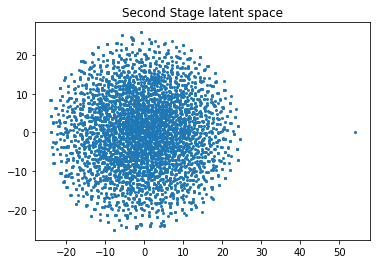

In [13]:
#First Stage encoding
h_1 = FirstStage.encoder(dataset.data)
q_1 = FirstStage.lsr(h_1)
z_1 = q_1.rsample()
z_1 = z_1.detach().cpu()


#second Stage encoding
z_2 = torch.Tensor(scaler.transform(z_1))
h_2 = SecondStage.encoder(z_2)

mu = SecondStage.fc_mu(h_2)
std = torch.exp(SecondStage.fc_var(h_2) / 2)
q_2 = torch.distributions.Normal(mu, std)

u = q_2.rsample()
u = u.detach().cpu()

u_embedded = TSNE(n_components=2).fit_transform(u.numpy())
plt.scatter(u_embedded[:, 0], u_embedded[:, 1], s=4)
plt.title("Second Stage latent space")
plt.show()

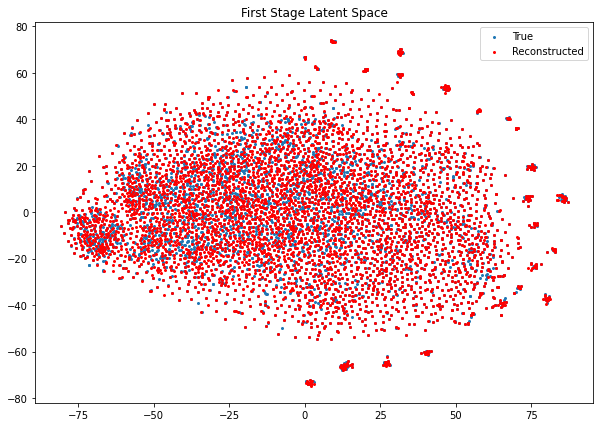

In [14]:
p_u = torch.distributions.Normal(torch.zeros(128), torch.ones(128))

reco_z = SecondStage.decoder(u.to(SecondStage.device)).cpu()
reco_z = reco_z + torch.exp(SecondStage.log_scale)*p_u.rsample((len(z_1),))
reco_z = torch.Tensor(scaler.inverse_transform(reco_z.detach()))

encodings = np.concatenate((z_1, reco_z), axis=0)
encodings_embedded = TSNE(n_components=2).fit_transform(encodings)

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.scatter(encodings_embedded[:len(z_1), 0], encodings_embedded[:len(z_1), 1], s=4)
ax.scatter(encodings_embedded[len(z_1):, 0], encodings_embedded[len(z_1):, 1], s=4, c='red')
plt.title("First Stage Latent Space")
plt.legend(["True", "Reconstructed"])
plt.show()


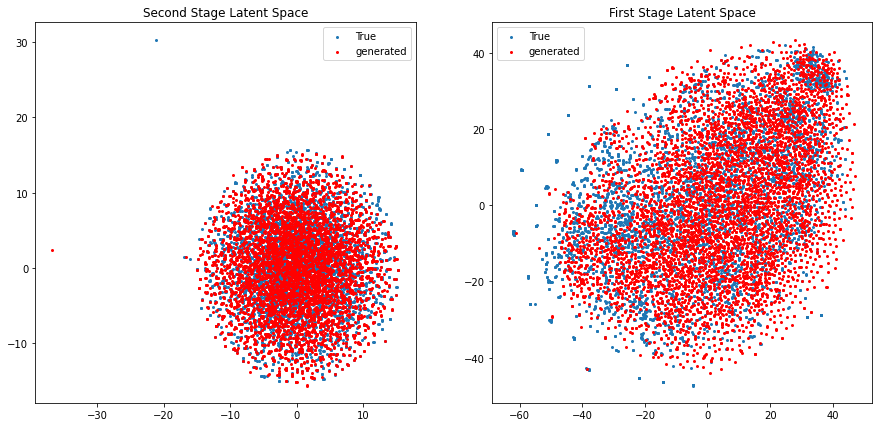

In [16]:
p_u = torch.distributions.Normal(torch.zeros(128), torch.ones(128))
n_gen = 5000
u_gen = p_u.rsample((n_gen,))

gen_z = SecondStage.decoder(u_gen.to(SecondStage.device)).cpu()
gen_z = gen_z + torch.exp(SecondStage.log_scale)*p_u.rsample((n_gen,))
gen_z = torch.Tensor(scaler.inverse_transform(gen_z.detach()))

encodings_U = np.concatenate((u, u_gen), axis=0)
encodings_Z = np.concatenate((z_1, gen_z), axis=0)
encodings_Z_embedded = TSNE(n_components=2).fit_transform(encodings_Z)
encodings_U_embedded = TSNE(n_components=2).fit_transform(encodings_U)

fig, ax = plt.subplots(1,2, figsize=(15, 7))
ax[0].scatter(encodings_U_embedded[:-n_gen, 0], encodings_U_embedded[:-n_gen, 1], s=4, label = "True")
ax[0].scatter(encodings_U_embedded[-n_gen:, 0], encodings_U_embedded[-n_gen:, 1], s=4, c='red', label = "generated")
ax[0].title.set_text("Second Stage Latent Space")
ax[0].legend()

ax[1].scatter(encodings_Z_embedded[:-n_gen, 0], encodings_Z_embedded[:-n_gen, 1], s=4, label = "True")
ax[1].scatter(encodings_Z_embedded[-n_gen:, 0], encodings_Z_embedded[-n_gen:, 1], s=4, c='red', label = "generated")
ax[1].title.set_text("First Stage Latent Space")
ax[1].legend()
plt.show()


In [17]:
def kl_loss(mu: torch.Tensor, std: torch.Tensor):
    """Computes close form of KL for gaussian distributions
    Args :
        mu : encoder means
        std : encoder stds

    To use it within the learning : take the sum and divide by the batch size
    """
    logstd = torch.log(std)
    return (torch.square(mu) + torch.square(std) - 2 * logstd - 1) / 2.0

In [24]:
std

tensor([[0.9782, 0.9154, 0.1952,  ..., 0.2870, 0.9838, 0.4292],
        [1.0116, 0.9287, 0.1960,  ..., 0.2892, 0.9968, 0.4272],
        [0.9602, 0.9571, 0.1936,  ..., 0.2782, 0.9994, 0.4404],
        ...,
        [1.0317, 0.9340, 0.2039,  ..., 0.2885, 0.9743, 0.4333],
        [0.9745, 0.9398, 0.1787,  ..., 0.2914, 1.0054, 0.4338],
        [0.9654, 0.9941, 0.2301,  ..., 0.2959, 1.0003, 0.4533]],
       grad_fn=<ExpBackward>)

In [18]:
#KLD pour l'espace latent du 2nd Stage
#On calcule en réalité la KLD de chacune des composante de la gaussienne multivariée par rapport à une N(0,1) car on considère la matrice de covariance diagonale
kl_loss(mu, std).mean()

tensor(0.2287, grad_fn=<MeanBackward0>)

In [19]:
#KLD pour l'espace latent du 1er Stage
kl_loss(FirstStage.lsr.dist_params(q_1)[1], FirstStage.lsr.dist_params(q_1)[2]).mean()

tensor(2.7000, grad_fn=<MeanBackward0>)

In [21]:
print(torch.exp(SecondStage.log_scale))
print(torch.exp(SecondStage.calculated_scale))

tensor([0.0908], grad_fn=<ExpBackward>)
tensor([1.0968])


# Reconstruction through 2 stages

- La version 12 avec batch norm + 256 256 256 n'est pas très performante malgré une meilleure loss
- La version 11 sans batch norm + 128 128 128 marche assez bien 
- Au lieu de passer directement à la génération, regarder comment se comporte la reconstruction en passant par le 2 stages VAE

In [10]:
from os import walk

filenames = next(walk("lightning_logs/version_44/checkpoints"), (None, None, []))[2]

# SecondStage = SecondStage_VAE.load_from_checkpoint(
#     "lightning_logs/version_10/checkpoints/" + filenames[0], 
#     hparams_file="lightning_logs/version_10/hparams.yaml",
# )

SecondStage = VAE.load_from_checkpoint(
    "lightning_logs/version_44/checkpoints/" + filenames[0], 
    hparams_file="lightning_logs/version_44/hparams.yaml",
)

SecondStage.eval()

VAE(
  (encoder): FCN(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (decoder): FCN(
    (layers): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (fc_mu): Linear(in_features=128, out_features=128, bias=True)
  (fc_var): Linear(in_features=128, out_features=128, bias=True)
  (out_activ): Tanh()
)

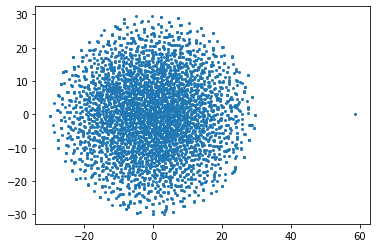

In [116]:
#First Stage encoding
h_1 = FirstStage.encoder(dataset.data)
q_1 = FirstStage.lsr(h_1)
z_1 = q_1.rsample()
z_1 = z_1.detach().cpu()

#second Stage encoding
# z_2 = torch.Tensor(scaler.transform(z_1))
# z_2 = z_1
# h_2 = SecondStage.encoder(z_2)
# q_2 = SecondStage.lsr(h_2)
# u = q_2.rsample()
# u = u.detach().cpu()

#second Stage encoding
z_2 = torch.Tensor(scaler.transform(z_1))
h_2 = SecondStage.encoder(z_2)

mu = SecondStage.fc_mu(h_2)
std = torch.exp(SecondStage.fc_var(h_2) / 2)
q_2 = torch.distributions.Normal(mu, std)

u = q_2.rsample()
u = u.detach().cpu()

u_embedded = TSNE(n_components=2).fit_transform(u.numpy())
plt.scatter(u_embedded[:, 0], u_embedded[:, 1], s=4)
plt.show()

In [117]:
a = np.where(u_embedded[:,1] > 40)[0]
a

array([], dtype=int64)

- ATTENTION a la reconstruction des Z après le second stage
- Pourquoi la reconstruction et l'original ne commencent pas aux même points ?

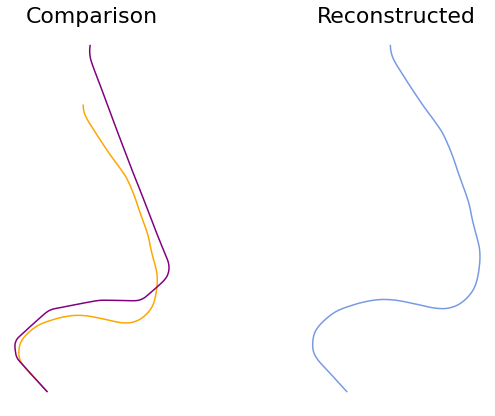

In [118]:
### Reconstruction
i = np.random.randint(len(dataset))
# i=4183
original, info = dataset[i]
p_u = torch.distributions.Normal(torch.zeros(128), torch.ones(128))

reco_z = SecondStage.decoder(u[i].unsqueeze(0).to(SecondStage.device)).cpu()
# reco_z = reco_z + SecondStage.scale*p_u.rsample()
# reco_z = reco_z + torch.exp(SecondStage.log_scale)*p_u.rsample()
reco_z = torch.Tensor(scaler.inverse_transform(reco_z.detach()))
reco_x = FirstStage.decoder(reco_z)

data = torch.cat((original.unsqueeze(0).transpose(1, 2), reco_x.detach().transpose(1, 2)))
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

#add lat/lon info (coordinates of the first point)
info = info.repeat(2, 1)
data = np.concatenate((info.numpy(), data), axis=1)

builder = FirstStage.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in FirstStage.hparams.features
]

reconstruction = traffic_from_data(
    data, features, FirstStage.dataset_params["info_params"]["features"], builder=builder
)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    reconstruction[1].plot(ax[0], c="orange", label="reconstructed")
    reconstruction[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    reconstruction[1].plot(ax[1])

    plt.show()

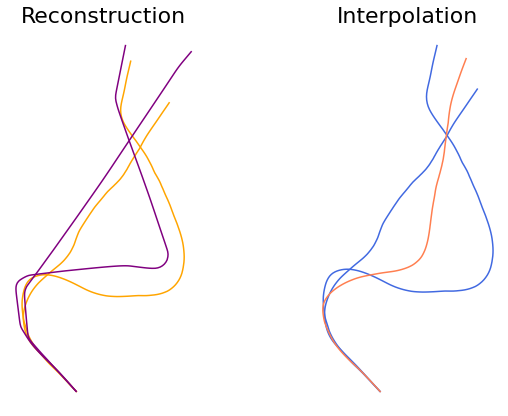

In [114]:
### Reconstruction
i = np.random.randint(len(dataset))
j = np.random.randint(len(dataset))
original, info = dataset[[i,j]]
p_u = torch.distributions.Normal(torch.zeros(128), torch.ones(128))

inter_u = (u[i]+u[j])/2
u_decode = torch.cat((u[[i,j]],inter_u.unsqueeze(0)))

reco_z = SecondStage.decoder(u_decode.to(SecondStage.device)).cpu()
# reco_z = reco_z + SecondStage.scale*p_u.rsample()
# reco_z = reco_z + torch.exp(SecondStage.log_scale)*p_u.rsample()
reco_z = torch.Tensor(scaler.inverse_transform(reco_z.detach()))
reco_x = FirstStage.decoder(reco_z)
reco_x = reco_x.detach().transpose(1,2).reshape(reco_x.shape[0],-1)

data = torch.cat((original.transpose(1, 2).reshape(reco_x.shape[0]-1,-1), reco_x))
data = data.view((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

#add lat/lon info
new_info = ((info[0]+info[1])/2).unsqueeze(0) 
info = info.repeat(2, 1)
info = torch.cat((info, new_info))
data = np.concatenate((info.numpy(), data), axis=1)

builder = FirstStage.get_builder(data.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in FirstStage.hparams.features
]

reconstruction = traffic_from_data(
    data, features, FirstStage.dataset_params["info_params"]["features"], builder=builder
)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Reconstruction")
    reconstruction[2:4].plot(ax[0], c="orange", label="reconstructed")
    reconstruction[:2].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Interpolation")
    reconstruction[2:4].plot(ax[1], c = "royalblue", label = "reconstructed")
    reconstruction[4].plot(ax[1], c = "coral", label = "interpolated")


    plt.show()

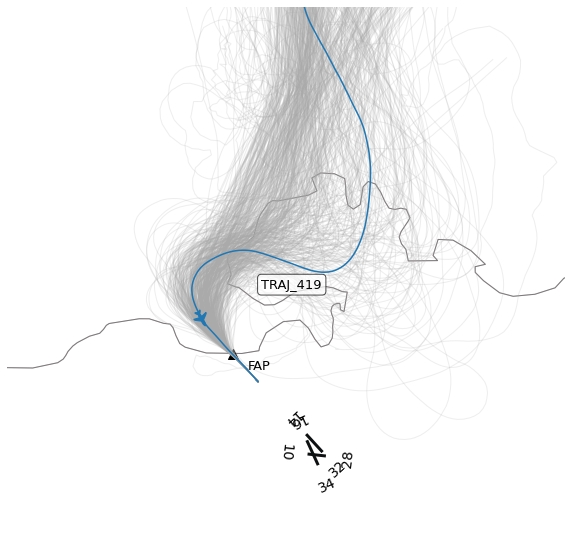

In [55]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import airports
from traffic.data import navaids

n_disp = 500
p_u = torch.distributions.Normal(torch.zeros(128), torch.ones(128))

### Reconstruction
with torch.no_grad():
    reco_z = SecondStage.decoder(u[:n_disp].to(SecondStage.device)).cpu()
    # reco_z = reco_z + SecondStage.scale*p_u.rsample((len(reco_z),))
    # reco_z = reco_z + torch.exp(SecondStage.log_scale)*p_u.rsample((len(reco_z),))
    reco_z = torch.Tensor(scaler.inverse_transform(reco_z))
    reco_x = FirstStage.decoder(reco_z)

reco_x = reco_x.detach().transpose(1,2).reshape(reco_x.shape[0],-1)
data_reco = dataset.scaler.inverse_transform(reco_x)

_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(len(data_reco), 1)
data_reco = np.concatenate((info.numpy(), data_reco), axis=1)

builder = FirstStage.get_builder(data_reco.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in FirstStage.hparams.features
]

reconstruction = traffic_from_data(
    data_reco, features, FirstStage.dataset_params["info_params"]["features"], builder=builder
)

i = np.random.randint(len(reconstruction))


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    reconstruction.plot(ax, alpha=0.2)
    reconstruction[i].plot(ax, color="#1f77b4", lw=1.5)
    reconstruction[i].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# Generation

ATTENTION AUX LAT LON info des trajectoires générées. On ne peut pas simplement reprendre les lat/lon info des trajetoires existantes !!!!!!!

In [11]:
# U COMES FROM NORMAL(0, 1) (Sampling within the 2nd stage)
num_preds = 1000
p_u = torch.distributions.Normal(torch.zeros(128), torch.ones(128))
u = p_u.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    gen_z = SecondStage.decoder(u.to(SecondStage.device)).cpu()
    # gen_z = gen_z + torch.exp(SecondStage.log_scale)*p_u.rsample((num_preds,))
    gen_z = torch.Tensor(scaler.inverse_transform(gen_z.detach()))
    gen_x = FirstStage.decoder(gen_z)

gen_x = gen_x.detach().transpose(1,2).reshape(gen_x.shape[0],-1)
data_gen = dataset.scaler.inverse_transform(gen_x)

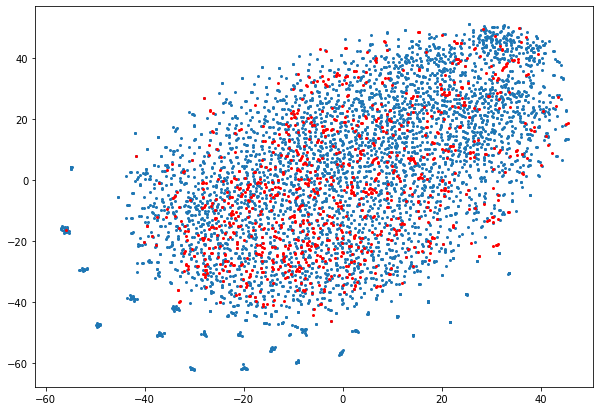

In [12]:
h = FirstStage.encoder(dataset.data)
q = FirstStage.lsr(h)
z = q.rsample()
z = z.detach().cpu().numpy()


encodings = np.concatenate((z, gen_z), axis=0)
# encodings = z
encodings_embedded = TSNE(n_components=2).fit_transform(encodings)

fig, ax = plt.subplots(1, figsize=(10, 7))
ax.scatter(encodings_embedded[:-num_preds, 0], encodings_embedded[:-num_preds, 1], s=4)
ax.scatter(encodings_embedded[-num_preds:, 0], encodings_embedded[-num_preds:, 1], s=4, c='red')
# ax.scatter(encodings_embedded[:, 0], encodings_embedded[:, 1], s=4)
plt.show()

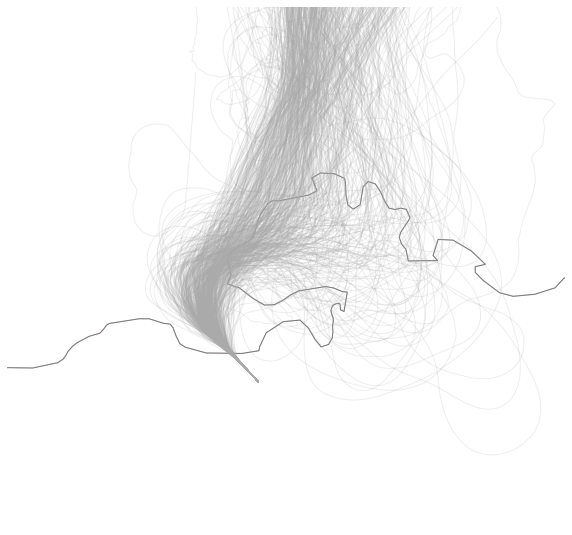

In [29]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import airports
from traffic.data import navaids
from os import walk

from traffic.algorithms.generation import ScalerProtocol
from typing import TYPE_CHECKING, Any, List, Optional, Tuple, Union, TypedDict

path_stage1 = "../../deep_traffic_generation/lightning_logs/tcvae/version_9/"
path_stage2 = "lightning_logs/version_44/"

class TwoStageVAEtoto:

    def __init__(self,
        X : TrafficDataset, #Traffic dataset used to train the first VAE stage  
        sim_type : "generation",
        scaler2 : Optional[ScalerProtocol] #the trained scaler for the second stage
        ):
        super().__init__()

        self.X = X
        self.scaler2 = scaler2
        self.sim_type = sim_type

        if sim_type not in ["generation", "reconstruction"]:
            raise ValueError("Invalid sim type. Expected one of: %s" % ["generation", "reconstruction"])

    def load(self, first_stage_path : str, second_stage_path : str, dataset_params : TypedDict):
        filenames1 = next(walk(first_stage_path + "checkpoints/"), (None, None, []))[2]
        filenames2 = next(walk(second_stage_path + "checkpoints/"), (None, None, []))[2]

        self.first_stage = TCVAE.load_from_checkpoint(
            first_stage_path + "checkpoints/" + filenames1[0],
            hparams_file=first_stage_path + "/hparams.yaml",
                dataset_params=dataset_params,
            )
        self.first_stage.eval()

        self.second_stage = VAE.load_from_checkpoint(
            path_stage2 + "checkpoints/" + filenames2[0], 
            hparams_file=path_stage2 + "/hparams.yaml",
            )
        self.second_stage.eval()
        
    def latent_spaces(self, n_samples : int): #Gives the latent spaces of the first stage, the second stage, and n_sample generated points within

        h = self.first_stage.encoder(self.X.data[:n_samples])
        q = self.first_stage.lsr(h)
        z_1 = q.rsample()
        z_1 = z_1.detach().cpu().numpy()
        z_2 = torch.Tensor(self.scaler2.transform(z_1))
        h_2 = self.second_stage.encoder(z_2)
        mu = self.second_stage.fc_mu(h_2)
        std = torch.exp(self.second_stage.fc_var(h_2) / 2)
        q_2 = torch.distributions.Normal(mu, std)
        u = q_2.rsample()

        p_u = torch.distributions.Normal(torch.zeros(self.second_stage.fc_mu.out_features), torch.ones(self.second_stage.fc_var.out_features))
        u_gen = p_u.rsample((n_samples,))

        z_gen = self.second_stage.decoder(u_gen.to(self.second_stage.device)).cpu()
        # z_gen = z_gen + torch.exp(self.second_stage.log_scale)*p_u.rsample((n_samples,))
        z_gen = torch.Tensor(self.scaler2.inverse_transform(z_gen.detach()))

        u_embeddings = np.concatenate((u, u_gen), axis=0)
        z_embeddings = np.concatenate((z_1, z_gen), axis=0)

        return u_embeddings, z_embeddings

    def fit(self, X, **kwargs):
        return self
        
    def sample(self, n_samples: int):  # Tuple[ndarray[float], ndarray[float]]

        with torch.no_grad():

            if self.sim_type == "generation":
                p_u = torch.distributions.Normal(torch.zeros(self.second_stage.fc_mu.out_features), torch.ones(self.second_stage.fc_var.out_features))
                u = p_u.rsample((n_samples,))
                

            #The reconstruction process goes through the 2 stages, even though the only first stage is way more efficient
            #The reconstruction through the 1st stage only will be implemented into the OneStageVAE GenerationProtocol
            if self.sim_type == "reconstruction":
                h = self.first_stage.encoder(self.X.data[:n_samples])
                q = self.first_stage.lsr(h)
                z_1 = q.rsample()
                z_1 = z_1.detach().cpu().numpy()
                z_2 = torch.Tensor(self.scaler2.transform(z_1))
                h_2 = self.second_stage.encoder(z_2)
                mu = self.second_stage.fc_mu(h_2)
                std = torch.exp(self.second_stage.fc_var(h_2) / 2)
                q_2 = torch.distributions.Normal(mu, std)
                u = q_2.rsample()

            gen_z = self.second_stage.decoder(u.to(self.second_stage.device)).cpu()
            # gen_z = gen_z + torch.exp(self.second_stage.log_scale)*p_u.rsample((n_samples,))
            gen_z = torch.Tensor(self.scaler2.inverse_transform(gen_z.detach()))
            gen_x = self.first_stage.decoder(gen_z)

        gen_x = gen_x.detach().transpose(1,2).reshape(gen_x.shape[0],-1)
        return gen_x, 0



from traffic.algorithms.generation import Generation
t = TwoStageVAEtoto(X = dataset, sim_type = "reconstruction", scaler2 = scaler)
t.load(path_stage1, path_stage2, dataset.parameters)
g = Generation(generation=t, features = FirstStage.hparams.features, scaler=dataset.scaler) #scaler of the first stage (the global scaler)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    t = g.sample(500, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False) #coordinates sont les coordonnées du dernier point car forward = False
    t.plot(ax, alpha=0.2)


In [147]:
t["TRAJ_0"].data

,track,groundspeed,altitude,timedelta,flight_id,callsign,icao24,timestamp,latitude,longitude
0,204.793874,291.027041,12424.587517,-0.010936,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:47:01.989064157+00:00,48.071484,47.778599
1,204.529881,290.233077,12363.469419,2.955897,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:47:04.955896795+00:00,48.067896,47.776156
2,204.194000,290.270342,12316.892348,5.247383,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:47:07.247382522+00:00,48.065117,47.774293
3,203.767736,289.862772,12256.309489,8.053177,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:47:10.053177297+00:00,48.061707,47.772054
4,203.430428,289.709721,12198.309278,10.586298,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:47:12.586298436+00:00,48.058623,47.770060
...,...,...,...,...,...,...,...,...,...,...
195,137.008333,164.950207,3490.179113,514.105431,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:55:36.105430722+00:00,47.552274,47.538750
196,137.019760,163.065179,3448.960261,516.524552,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:55:38.524552464+00:00,47.550952,47.540570
197,137.012260,161.023630,3406.564930,519.468347,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:55:41.468347132+00:00,47.549364,47.542757
198,136.975808,159.383458,3379.521057,521.818143,TRAJ_0,TRAJ_0,TRAJ_0,2022-01-07 13:55:43.818142682+00:00,47.548110,47.544486


In [150]:
import traffic
traffic.__path__

['/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/traffic']

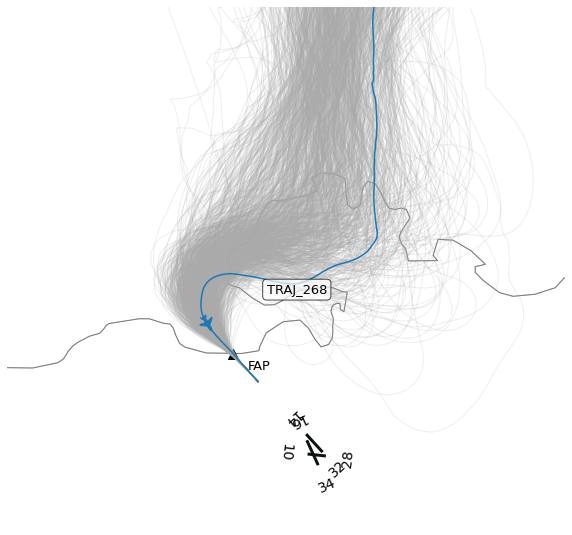

In [136]:
import matplotlib.pyplot as plt
from traffic.core.projection import CH1903p, EuroPP
from traffic.drawing import countries
from traffic.data import airports
from traffic.data import navaids

# add latitude longitude info
_, info = dataset[0] #lat/lon info from original dataset
info = info.repeat(num_preds, 1)
data_gen = np.concatenate((info.numpy(), data_gen), axis=1)

builder = FirstStage.get_builder(data_gen.shape[0], dataset.seq_len)
features = [
    "track" if "track" in f else f for f in FirstStage.hparams.features
]
generation = traffic_from_data(
    data_gen, features, FirstStage.dataset_params["info_params"]["features"], builder=builder
)

i = np.random.randint(len(generation))


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    generation.plot(ax, alpha=0.2)
    generation[i].plot(ax, color="#1f77b4", lw=1.5)
    generation[i].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

In [143]:
generation[0].data[["latitude", "longitude"]]

,latitude,longitude
0,48.025274,8.685815
1,48.022210,8.682351
2,48.020014,8.679839
3,48.017190,8.676563
4,48.014718,8.673658
...,...,...
195,47.552267,8.439745
196,47.550831,8.441754
197,47.549243,8.443987
198,47.547937,8.445829


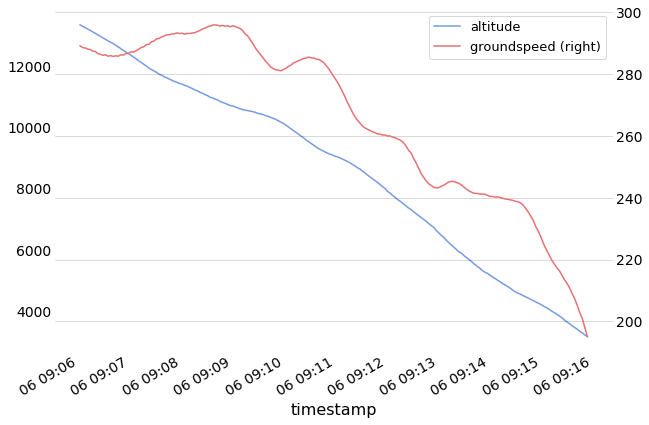

In [175]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    generation[int(i)].plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"]
    )

In [14]:
test = generation.cumulative_distance().eval()

In [15]:
test.data[["flight_id", "cumdist"]].groupby(["flight_id"]).max().sort_values(by="cumdist")

,cumdist
flight_id,
TRAJ_714,17.717325
TRAJ_707,18.150383
TRAJ_84,18.422551
TRAJ_102,20.562585
TRAJ_680,20.801644
...,...
TRAJ_487,87.401482
TRAJ_32,87.636900
TRAJ_836,92.934982


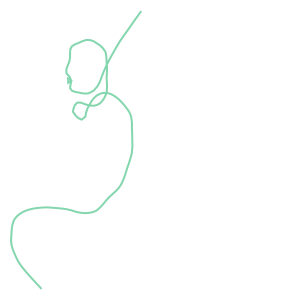

In [28]:
f = test["TRAJ_969"]
f

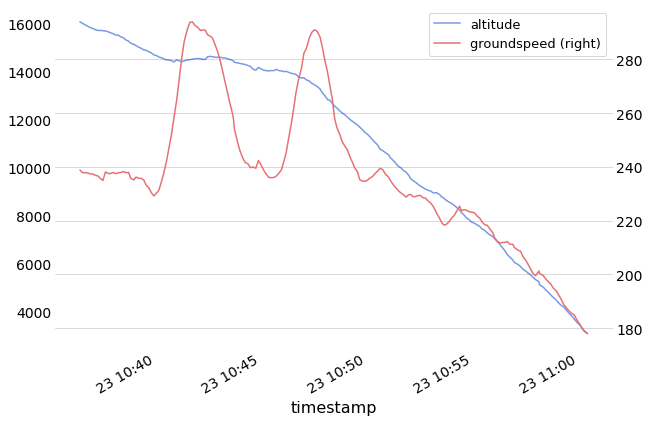

In [29]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(10, 7))
    f.plot_time(
        ax, y=["altitude", "groundspeed"], secondary_y=["groundspeed"]
    )